### Email (Gmail Agent)

In [1]:
import os
import base64
import quopri
import json
import time
from typing_extensions import TypedDict, Optional
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from langchain_ollama import ChatOllama
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

In [2]:
SCOPES = [
    "https://www.googleapis.com/auth/gmail.modify",
    "https://www.googleapis.com/auth/gmail.send",
]

TOKEN_PATH = "token.json"
CLIENT_SECRET_FILE = "credentials.json"

def get_credentials():
    creds = None

    # Load existing credentials if available
    if os.path.exists(TOKEN_PATH):
        with open(TOKEN_PATH, "r") as token:
            try:
                creds_info = json.load(token)
                creds = Credentials.from_authorized_user_info(creds_info, SCOPES)
            except json.JSONDecodeError:
                print("⚠️  Invalid token file. Re-authenticating...")
                creds = None

    # If credentials are missing, expired, or lack required scopes, get new ones
    if not creds or not creds.valid or not creds.has_scopes(SCOPES):
        if os.path.exists(TOKEN_PATH):
            os.remove(TOKEN_PATH)  # Remove old/invalid token
        if not os.path.exists(CLIENT_SECRET_FILE):
            raise FileNotFoundError("⚠️  Missing credentials.json file!")

        print("🔐  Requesting new authentication...")
        flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRET_FILE, SCOPES)
        creds = flow.run_local_server(port=5000)  # Use fixed port

        # Save new token
        with open(TOKEN_PATH, "w") as token:
            token.write(creds.to_json())

    return creds

In [5]:
creds = get_credentials()
service = build("gmail", "v1", credentials=creds)

⚠️  Invalid token file. Re-authenticating...
🔐  Requesting new authentication...
Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=555540938979-k7g9ca5fbkhc149guvo9vdl87un2mep7.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A5000%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fgmail.modify+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fgmail.send&state=7kgQQ47vR4gXtxn8cKYbXSVk6gKqLX&access_type=offline


In [6]:


# Email functions
def send_email(service, to, subject, message_text, user_id="me"):
    try:
        message = MIMEMultipart()
        message["to"] = to
        message["subject"] = subject
        message.attach(MIMEText(message_text, "plain"))
        raw = base64.urlsafe_b64encode(message.as_bytes()).decode()
        message_body = {"raw": raw}
        sent_message = service.users().messages().send(userId=user_id, body=message_body).execute()
        print(f"✅ Email sent to {to} (ID: {sent_message['id']})")
        return True
    except Exception as e:
        print(f"❌ Failed to send email to {to}: {e}")
        return False

def get_email_body(payload):
    def decode_part(part):
        body = part.get('body', {}).get('data', '')
        if body:
            data = base64.urlsafe_b64decode(body.encode('UTF-8'))
            if part.get('mimeType') == 'text/plain':
                return data.decode('UTF-8')
            elif part.get('mimeType') == 'text/html':
                return quopri.decodestring(data).decode('UTF-8')
        elif 'parts' in part:
            return ''.join([decode_part(p) for p in part['parts']])
        return ''
    return decode_part(payload)

In [7]:
def get_or_create_label(service, label_name):
    labels = service.users().labels().list(userId='me').execute().get('labels', [])
    label = next((label for label in labels if label['name'] == label_name), None)
    if label:
        return label['id']
    else:
        label_body = {
            'name': label_name,
            'labellistVisibility': 'labelShow',
            'messagelistVisibility': 'show',
            'type': 'user'
        }
        label = service.users().labels().create(userId='me', body=label_body).execute()
        return label['id']

# CSV Processing
def get_csv_path() -> Optional[str]:
    """Find the CSV file in parent directory"""
    try:
        script_dir = os.path.dirname(os.path.abspath(__file__))
    except NameError:
        script_dir = os.getcwd()
    
    parent_dir = os.path.dirname(script_dir)
    for filename in ['ziellabs_leads.csv', 'global_marketing_leads.csv']:
        path = os.path.join(parent_dir, filename)
        if os.path.exists(path):
            return path
    return None

In [8]:
import csv

def read_leads_from_csv() -> list[dict]:
    """Read and process leads from CSV"""
    csv_path = get_csv_path()
    if not csv_path:
        print("No CSV file found in parent directory")
        return []
    
    leads = []
    try:
        with open(csv_path, mode='r', encoding='utf-8') as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                # Handle both CSV formats
                emails = []
                if 'emails' in row and row.get('status') == 'Success':
                    emails = [e.strip() for e in row['emails'].split(',') if e.strip()]
                elif 'email' in row and row['email']:
                    emails = [row['email'].strip()]
                
                for email in emails:
                    lead = {
                        'email': email,
                        'company': row.get('company', ''),
                        'name': row.get('name', ''),
                        'website': row.get('website', ''),
                        'service_category': row.get('service_category', '')
                    }
                    leads.append(lead)
        print(f"Found {len(leads)} valid leads in {os.path.basename(csv_path)}")
    except Exception as e:
        print(f"Error reading CSV: {e}")
    
    return leads

In [9]:
class GradeEmail(BaseModel):
    score: str = Field(description="Is the email normal? If yes -> 'Yes', if not -> 'No'")

def generate_personalized_message(lead: dict) -> str:
    """Generate email content using LLM"""
    system_prompt = """You are a marketing assistant that generates professional, personalized emails. 
    Write only the email body text (no subject or greetings)."""
    
    prompt_text = f"""
    Write a marketing email for:
    Company: {lead.get('company', '')}
    Contact: {lead.get('name', '')}
    Service: {lead.get('service_category', '')}
    """
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("human", prompt_text)
    ])
    
    llm = ChatOllama(model="llama3.2")
    chain = prompt | llm | StrOutputParser()
    return chain.invoke({})

In [10]:
class AgentState(TypedDict):
    initialized: bool
    initial_messages_sent: bool
    new_email: dict
    email_classification: str
    llm_output: str
    processed_email_ids: list[str]

def send_initial_messages(state: AgentState) -> AgentState:
    """Send initial emails to leads from CSV"""
    if state.get('initial_messages_sent', False):
        return state
    
    leads = read_leads_from_csv()
    if not leads:
        state['initial_messages_sent'] = True
        return state
    
    successful = 0
    for lead in leads:
        email = lead.get('email')
        if not email:
            continue
            
        message = generate_personalized_message(lead)
        subject = f"Partnership opportunity with {lead.get('company', 'your company')}"
        
        if send_email(service, email, subject, message):
            successful += 1
            time.sleep(10)  # Rate limiting
        
    print(f"Sent {successful}/{len(leads)} initial emails")
    state['initial_messages_sent'] = True
    return state

In [11]:
def check_for_new_emails(state: AgentState) -> AgentState:
    """Check for new unprocessed emails"""
    print("Checking for new emails...")
    
    if not state.get('initialized', False):
        print("Initializing state for the first time...")
        state['initialized'] = True
        results = service.users().messages().list(
            userId='me', 
            labelIds=['INBOX'], 
            maxResults=10
        ).execute()
        messages = results.get('messages', [])
        state['processed_email_ids'] = [msg['id'] for msg in messages]
        state['new_email'] = None
        return state
    
    results = service.users().messages().list(
        userId='me', 
        labelIds=['INBOX'], 
        maxResults=10
    ).execute()
    messages = results.get('messages', [])
    processed_ids = set(state.get('processed_email_ids', []))
    emails_to_process = [msg for msg in messages if msg['id'] not in processed_ids]
    
    if emails_to_process:
        email_id = emails_to_process[0]['id']
        email = service.users().messages().get(
            userId='me', 
            id=email_id, 
            format='full'
        ).execute()
        state['new_email'] = email
    else:
        state['new_email'] = None
    
    return state

In [12]:
def classify_email(state: AgentState) -> AgentState:
    """Classify email as personal or automated"""
    email = state.get('new_email')
    if not email:
        state['email_classification'] = 'No new email'
        return state
    
    payload = email.get('payload', {})
    headers = payload.get('headers', [])
    subject = next((h['value'] for h in headers if h['name'] == 'Subject'), '')
    sender = next((h['value'] for h in headers if h['name'] == 'From'), '')
    body = get_email_body(payload)
    email_content = f"From: {sender}\nSubject: {subject}\n\n{body}"
    
    system_prompt = """Classify emails as 'Yes' (personal) or 'No' (automated):
    Yes - From real people (e.g., colleagues, clients)
    No - Automated messages (e.g., confirmations, newsletters)"""
    
    grade_prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("human", "Email content:\n\n{email_content}\n\nClassification?")
    ])
    
    llm = ChatOllama(model="llama3.2")
    structured_llm = llm.with_structured_output(GradeEmail)
    classifier = grade_prompt | structured_llm
    result = classifier.invoke({"email_content": email_content})
    
    state['email_classification'] = result.score
    print(f"Email classified as: {result.score}")
    return state

def generate_response(state: AgentState) -> AgentState:
    """Generate response to personal emails"""
    email = state.get('new_email')
    if not email:
        return state
    
    payload = email.get('payload', {})
    headers = payload.get('headers', [])
    subject = next((h['value'] for h in headers if h['name'] == 'Subject'), '')
    sender = next((h['value'] for h in headers if h['name'] == 'From'), '')
    body = get_email_body(payload)
    email_content = f"From: {sender}\nSubject: {subject}\n\n{body}"
    
    system_prompt = """You are an assistant that generates polite email replies.
    Write the response text only (no headers or signatures)."""
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("human", "Email to respond to:\n\n{email_content}\n\nYour response:")
    ])
    
    llm = ChatOllama(model="llama3.2")
    chain = prompt | llm | StrOutputParser()
    response = chain.invoke({"email_content": email_content})
    
    state['llm_output'] = response
    return state

def send_email_response(state: AgentState) -> AgentState:
    """Send the generated response"""
    email = state.get('new_email')
    if not email or not state.get('llm_output'):
        return state
    
    payload = email.get('payload', {})
    headers = payload.get('headers', [])
    sender = next((h['value'] for h in headers if h['name'] == 'From'), '')
    subject = next((h['value'] for h in headers if h['name'] == 'Subject'), 'No Subject')
    
    send_email(service, sender, f"Re: {subject}", state['llm_output'])
    return state

In [13]:
def flag_email(state: AgentState) -> AgentState:
    """Label and archive the processed email"""
    email = state.get('new_email')
    if not email:
        return state
    
    email_id = email['id']
    classification = state.get('email_classification', '').lower()
    
    if classification == 'yes':
        label_name = 'FLAGGED_PERSONAL'
    elif classification == 'no':
        label_name = 'FLAGGED_AUTOMATED'
    else:
        return state
    
    label_id = get_or_create_label(service, label_name)
    
    # Apply label and mark as read
    service.users().messages().modify(
        userId='me',
        id=email_id,
        body={
            'addLabelIds': [label_id],
            'removeLabelIds': ['UNREAD']
        }
    ).execute()
    
    # Update processed emails list
    if 'processed_email_ids' not in state:
        state['processed_email_ids'] = []
    state['processed_email_ids'].append(email_id)
    state['new_email'] = None
    
    print(f"Email flagged as: {label_name}")
    return state

In [14]:
def new_email_router(state: AgentState) -> str:
    """Route based on new email presence"""
    if not state.get('initialized', False):
        return "__end__"
    return 'classify_email' if state.get('new_email') else "__end__"

def classification_router(state: AgentState) -> str:
    """Route based on email classification"""
    classification = state.get('email_classification', '').lower()
    return 'generate_response' if classification == 'yes' else 'flag_email'

In [22]:
workflow = StateGraph(AgentState)

# Add nodes in any order since all functions are now defined
workflow.add_node('send_initial_messages', send_initial_messages)
workflow.add_node('check_emails', check_for_new_emails)
workflow.add_node('classify_email', classify_email)
workflow.add_node('generate_response', generate_response)
workflow.add_node('send_response', send_email_response)
workflow.add_node('flag_email', flag_email)

# Set up routing

workflow.add_conditional_edges('check_emails', new_email_router, {
    'classify_email': 'classify_email',
    '__end__': END
})
workflow.add_conditional_edges('classify_email', classification_router, {
    'generate_response': 'generate_response',
    'flag_email': 'flag_email'
})

workflow.add_edge('send_initial_messages', 'check_emails')
workflow.add_edge('generate_response', 'send_response')
workflow.add_edge('send_response', 'flag_email')
workflow.add_edge('flag_email', END)

workflow.set_entry_point('send_initial_messages')

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

In [23]:
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
config = {"configurable": {"thread_id": "1"}}

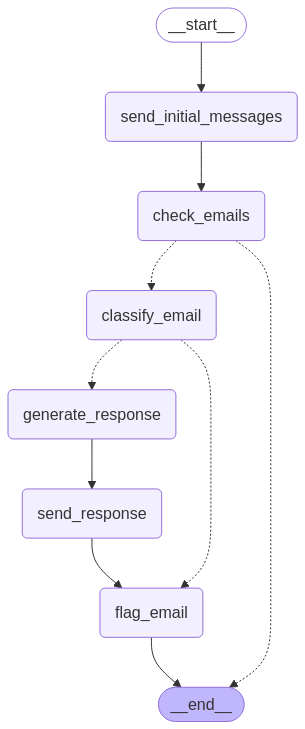

In [24]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:


def run_email_workflow(config):
    """Run the workflow continuously"""
    initialized = False
    while True:
        try:
            state = {"initialized": initialized, "initial_messages_sent": False}
            app.invoke(state, config=config)
            initialized = True
            time.sleep(60)  # Check every minute
        except Exception as e:
            print(f"Workflow error: {e}")
            time.sleep(300)  # Wait 5 minutes after errors

if __name__ == "__main__":
    print("Starting email workflow...")
    run_email_workflow(config)

Starting email workflow...
Found 14 valid leads in ziellabs_leads.csv
✅ Email sent to fern@medg.lcs.mit.edu (ID: 195e80affa8e3d4f)
✅ Email sent to accommodation@twilio.com (ID: 195e80b5ea34772a)
✅ Email sent to accommodations@twilio.com (ID: 195e80bc1bcb714d)
✅ Email sent to customer.service@e.org (ID: 195e80c2494629ef)
✅ Email sent to tenancy@e.org (ID: 195e80c959009658)
✅ Email sent to 555-555-5555mymail@mailservice.com (ID: 195e80cf5c6b0a62)
✅ Email sent to projects@shapestudio.co.uk (ID: 195e80d661dbccfd)
✅ Email sent to sales@kwanzoo.com (ID: 195e80dd31ab2512)
✅ Email sent to in@ml.org (ID: 195e80e2c2227d8c)
✅ Email sent to ll@ml.org (ID: 195e80e9308a6749)
✅ Email sent to hxwsales@teamhorner.com (ID: 195e80ef42e01ae5)
✅ Email sent to press@character.ai (ID: 195e80f60ac3ae48)


KeyboardInterrupt: 